# 🎾Калибровка модели RandomForest 200 10

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, log_loss, \
    confusion_matrix, brier_score_loss
import warnings

warnings.filterwarnings('ignore')


# Функция для имитации реалистичных пропусков в теннисных данных
def create_realistic_tennis_missing_data(tennis_df, random_state=None):
    np.random.seed(random_state)
    df = tennis_df.copy()

    # 1. Рейтинг и очки чаще отсутствуют у малоизвестных игроков (с высоким рейтингом)
    high_rank_mask = df['Rank_1'] > 100
    df.loc[high_rank_mask & (np.random.random(len(df)) < 0.3), 'Pts_1'] = np.nan

    high_rank_mask = df['Rank_2'] > 100
    df.loc[high_rank_mask & (np.random.random(len(df)) < 0.3), 'Pts_2'] = np.nan

    # 2. Коэффициенты могут отсутствовать для некоторых матчей
    df.loc[np.random.random(len(df)) < 0.1, ['Odd_1', 'Odd_2']] = np.nan

    # 3. Счет может быть неполным для незавершенных матчей
    # Имитируем отсутствие последних сетов
    def truncate_score(score, prob_missing=0.15):
        if pd.isna(score) or np.random.random() > prob_missing:
            return score

        sets = score.split()
        if len(sets) <= 1:
            return score

        # Сохраняем только первый сет с вероятностью 0.7, иначе первые два
        n_sets = 1 if np.random.random() < 0.7 else 2
        n_sets = min(n_sets, len(sets))

        return ' '.join(sets[:n_sets])

    df['Score'] = df['Score'].apply(lambda x: truncate_score(x))

    return df


# Функция для извлечения признаков из счета матча
def extract_score_features(score):
    if pd.isna(score):
        return [0] * 6

    sets = score.split()
    total_sets = len(sets)
    sets_won_1 = 0
    sets_won_2 = 0
    total_games_1 = 0
    total_games_2 = 0

    for set_score in sets:
        games = set_score.split('-')
        if len(games) == 2:
            games_1 = int(games[0])
            games_2 = int(games[1])
            total_games_1 += games_1
            total_games_2 += games_2
            if games_1 > games_2:
                sets_won_1 += 1
            else:
                sets_won_2 += 1

    return [total_sets, sets_won_1, sets_won_2,
            total_games_1, total_games_2,
            total_games_1 + total_games_2]


# Функция для создания дополнительных признаков
def create_comparison_features(df):
    features = pd.DataFrame()

    # Рейтинговое преимущество (чем больше разница, тем сильнее преимущество)
    features['rank_advantage'] = (df['Rank_2'] - df['Rank_1']) / (df['Rank_1'] + df['Rank_2'])

    # Очковое преимущество
    features['points_advantage'] = (df['Pts_1'] - df['Pts_2']) / (df['Pts_1'] + df['Pts_2'])

    # Преимущество по коэффициентам
    features['odds_advantage'] = (df['Odd_2'] - df['Odd_1']) / (df['Odd_1'] + df['Odd_2'])

    # Бинарные признаки для прямого сравнения
    features['better_rank'] = (df['Rank_1'] < df['Rank_2']).astype(int)
    features['more_points'] = (df['Pts_1'] > df['Pts_2']).astype(int)
    features['better_odds'] = (df['Odd_1'] < df['Odd_2']).astype(int)

    # Составной показатель преимущества
    features['overall_advantage'] = (features['better_rank'] +
                                     features['more_points'] +
                                     features['better_odds']) / 3

    # Добавляем квадраты и взаимодействия признаков
    features['rank_points_interaction'] = features['rank_advantage'] * features['points_advantage']
    features['rank_odds_interaction'] = features['rank_advantage'] * features['odds_advantage']
    features['points_odds_interaction'] = features['points_advantage'] * features['odds_advantage']

    return features


# Обновленная функция подготовки данных
def prepare_data(df):
    df = df.copy()

    # Конвертируем дату в datetime
    df['Date'] = pd.to_datetime(df['Date'])

    # Заменяем отрицательные значения на NaN
    numeric_columns = ['Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2']
    for col in numeric_columns:
        df.loc[df[col] < 0, col] = np.nan

    # Извлекаем признаки из счета
    score_features = df['Score'].apply(extract_score_features)
    score_features_df = pd.DataFrame(score_features.tolist(),
                                     columns=['total_sets', 'sets_won_1', 'sets_won_2',
                                              'total_games_1', 'total_games_2', 'total_games'])

    # Создаем признак результата
    df['target'] = (df['Winner'] == df['Player_1']).astype(int)

    # Кодируем категориальные признаки
    le = LabelEncoder()
    categorical_columns = ['Series', 'Court', 'Surface', 'Round']
    for col in categorical_columns:
        df[col + '_encoded'] = le.fit_transform(df[col])

    # Добавляем новые признаки сравнения
    comparison_features = create_comparison_features(df)

    # Объединяем все признаки
    features = pd.concat([
        df[['Rank_1', 'Rank_2', 'Pts_1', 'Pts_2', 'Odd_1', 'Odd_2']],
        df[[col + '_encoded' for col in categorical_columns]],
        score_features_df,
        comparison_features
    ], axis=1)

    return features, df['target']


# Функция для обучения модели с настроенными параметрами
def train_model(df_train):
    X, y = prepare_data(df_train)

    # Заполняем пропущенные значения
    X = X.fillna(X.mean())

    # Создаем модель с увеличенным числом деревьев и настроенными параметрами
    base_model = RandomForestClassifier(
        n_estimators=200,  # Увеличиваем количество деревьев
        max_depth=10,  # Ограничиваем глубину для избежания переобучения
        min_samples_split=10,  # Минимальное количество образцов для разделения
        min_samples_leaf=5,  # Минимальное количество образцов в листе
        random_state=32,
        class_weight='balanced'  # Балансируем веса классов
    )
    
    # Калибруем модель с использованием кросс-валидации
    calibrated_model = CalibratedClassifierCV(
        base_model, 
        method='sigmoid',  # Используем Platt scaling
        cv=3  # 3-fold кросс-валидация для калибровки
    )
    calibrated_model.fit(X, y)

    return base_model.fit(X, y), calibrated_model


# Функции get_predictions остаются без изменений
def get_predictions(model, df_test):
    X_test, _ = prepare_data(df_test)
    X_test = X_test.fillna(X_test.mean())
    probabilities = model.predict_proba(X_test)
    return probabilities


# Функция для создания таблицы результатов
def create_results_table(df_test, predictions):
    results = pd.DataFrame({
        'Player_1': df_test['Player_1'],
        'Player_1_Prediction': predictions[:, 1] * 100,
        'Player_2': df_test['Player_2'],
        'Player_2_Prediction': predictions[:, 0] * 100,
        'Winner': df_test['Winner'],
        'Rank_1': df_test['Rank_1'],
        'Rank_2': df_test['Rank_2'],
        'Pts_1': df_test['Pts_1'],
        'Pts_2': df_test['Pts_2'],
        'Odd_1': df_test['Odd_1'],
        'Odd_2': df_test['Odd_2'],
        'Score': df_test['Score']
    })

    # Определяем, кого модель прогнозирует победителем
    results['predicted_winner'] = np.where(predictions[:, 1] > predictions[:, 0],
                                           df_test['Player_1'],
                                           df_test['Player_2'])

    # Определяем, было ли предсказание верным
    results['correct_prediction'] = (results['predicted_winner'] == df_test['Winner'])

    # Добавляем уверенность в прогнозе - максимальная из двух вероятностей
    results['confidence'] = np.maximum(predictions[:, 0], predictions[:, 1]) * 100

    return results


# Функция для создания диаграммы надёжности
def plot_calibration_curve(y_true, y_proba_uncalibrated, y_proba_calibrated, title="Диаграмма надёжности"):
    """
    Создает диаграмму надёжности для сравнения некалиброванной и калиброванной модели
    """
    plt.figure(figsize=(10, 8))
    
    # Калибровочная кривая для некалиброванной модели
    fraction_of_positives_uncal, mean_predicted_value_uncal = calibration_curve(
        y_true, y_proba_uncalibrated, n_bins=10
    )
    
    # Калибровочная кривая для калиброванной модели
    fraction_of_positives_cal, mean_predicted_value_cal = calibration_curve(
        y_true, y_proba_calibrated, n_bins=10
    )
    
    # Строим диагональную линию (идеальная калибровка)
    plt.plot([0, 1], [0, 1], 'k--', label='Идеальная калибровка', alpha=0.7)
    
    # Диаграмма для некалиброванной модели
    plt.plot(mean_predicted_value_uncal, fraction_of_positives_uncal, 'o-', 
             label='Random Forest (некалиброванная)', color='red', markersize=8)
    
    # Диаграмма для калиброванной модели
    plt.plot(mean_predicted_value_cal, fraction_of_positives_cal, 's-', 
             label='Random Forest (калиброванная)', color='blue', markersize=8)
    
    plt.xlabel('Средняя предсказанная вероятность', fontsize=12)
    plt.ylabel('Доля положительных случаев', fontsize=12)
    plt.title(title, fontsize=14)
    plt.legend(fontsize=12)
    plt.grid(True, alpha=0.3)
    
    # Вычисляем и выводим Brier Score
    brier_uncal = brier_score_loss(y_true, y_proba_uncalibrated)
    brier_cal = brier_score_loss(y_true, y_proba_calibrated)
    
    plt.text(0.1, 0.9, f'Brier Score (некалиброванная): {brier_uncal:.4f}', 
             transform=plt.gca().transAxes, fontsize=11, bbox=dict(boxstyle="round", facecolor='wheat', alpha=0.5))
    plt.text(0.1, 0.85, f'Brier Score (калиброванная): {brier_cal:.4f}', 
             transform=plt.gca().transAxes, fontsize=11, bbox=dict(boxstyle="round", facecolor='lightblue', alpha=0.5))
    
    plt.tight_layout()
    plt.show()


# Функция для отображения результатов
def display_results(results):
    styled_results = results.style.format({
        'Player_1_Prediction': '{:.2f}%',
        'Player_2_Prediction': '{:.2f}%',
        'Rank_1': '{:.0f}',
        'Rank_2': '{:.0f}',
        'Pts_1': '{:.0f}',
        'Pts_2': '{:.0f}',
        'Odd_1': '{:.2f}',
        'Odd_2': '{:.2f}'
    }).apply(lambda x: ['background-color: #90EE90' if x['correct_prediction']
                        else 'background-color: #FFB6C6' for i in range(len(x))], axis=1)

    display(styled_results.hide(axis='columns', subset=['correct_prediction']))


# Обновленная функция для оценки и вывода метрик
def display_metrics(model, df_test, predictions, results, model_name=""):
    # Истинные значения (1 - если победил первый игрок, 0 - если второй)
    y_true = (df_test['Winner'] == df_test['Player_1']).astype(int)

    # Предсказанные вероятности победы первого игрока
    y_pred_proba = predictions[:, 1]

    # Предсказанные бинарные метки
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Расчет метрик
    accuracy = accuracy_score(y_true, y_pred) * 100
    precision = precision_score(y_true, y_pred) * 100
    recall = recall_score(y_true, y_pred) * 100
    f1 = f1_score(y_true, y_pred) * 100
    roc_auc = roc_auc_score(y_true, y_pred_proba) * 100
    entropy_loss = log_loss(y_true, y_pred_proba)
    brier_score = brier_score_loss(y_true, y_pred_proba)

    # Матрица ошибок
    cm = confusion_matrix(y_true, y_pred)
    tn, fp, fn, tp = cm.ravel()

    # Выводим метрики
    print(f"\nМетрики качества модели {model_name}:")
    print(f"Accuracy (Точность): {accuracy:.2f}%")
    print(f"Precision (Точность по положительному классу): {precision:.2f}%")
    print(f"Recall (Полнота): {recall:.2f}%")
    print(f"F1-score (F-мера): {f1:.2f}%")
    print(f"ROC AUC: {roc_auc:.2f}%")
    print(f"Log Loss: {entropy_loss:.4f}")
    print(f"Brier Score: {brier_score:.4f}")

    # Анализ ошибок
    print("\nМатрица ошибок (Confusion Matrix):")
    print(f"True Negative: {tn} (Правильно предсказанные победы второго игрока)")
    print(f"False Positive: {fp} (Неправильно предсказанные победы первого игрока)")
    print(f"False Negative: {fn} (Неправильно предсказанные победы второго игрока)")
    print(f"True Positive: {tp} (Правильно предсказанные победы первого игрока)")

    # Расчет метрик по уверенности прогноза
    confidence_bins = [50, 60, 70, 80, 90, 100]
    print("\nТочность предсказаний по уровню уверенности:")

    for i in range(len(confidence_bins) - 1):
        low = confidence_bins[i]
        high = confidence_bins[i + 1]

        # Фильтруем предсказания по уровню уверенности
        confident_preds = results[(results['confidence'] >= low) & (results['confidence'] < high)]

        if len(confident_preds) > 0:
            bin_accuracy = (confident_preds['correct_prediction'].sum() / len(confident_preds)) * 100
            print(f"Уверенность {low}%-{high}%: {bin_accuracy:.2f}% точность ({len(confident_preds)} матчей)")
        else:
            print(f"Уверенность {low}%-{high}%: нет матчей")

---

Размер тренировочного набора: 64018
Размер тестового набора: 123

Метрики качества модели (некалиброванная):
Accuracy (Точность): 94.31%
Precision (Точность по положительному классу): 90.91%
Recall (Полнота): 98.36%
F1-score (F-мера): 94.49%
ROC AUC: 99.10%
Log Loss: 0.1269
Brier Score: 0.0443

Матрица ошибок (Confusion Matrix):
True Negative: 56 (Правильно предсказанные победы второго игрока)
False Positive: 6 (Неправильно предсказанные победы первого игрока)
False Negative: 1 (Неправильно предсказанные победы второго игрока)
True Positive: 60 (Правильно предсказанные победы первого игрока)

Точность предсказаний по уровню уверенности:
Уверенность 50%-60%: 68.18% точность (22 матчей)
Уверенность 60%-70%: 100.00% точность (1 матчей)
Уверенность 70%-80%: нет матчей
Уверенность 80%-90%: нет матчей
Уверенность 90%-100%: 100.00% точность (100 матчей)

Метрики качества модели (калиброванная):
Accuracy (Точность): 91.87%
Precision (Точность по положительному классу): 86.96%
Recall (Полнота):

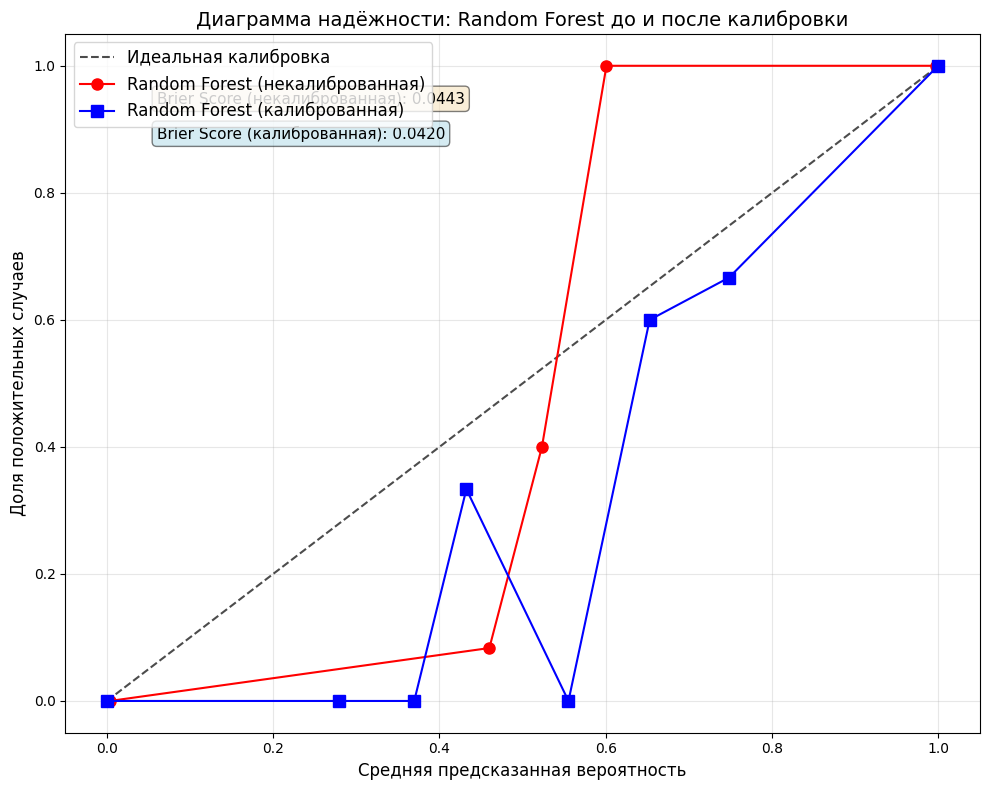


Результаты калиброванной модели:


,Player_1,Player_1_Prediction,Player_2,Player_2_Prediction,Winner,Rank_1,Rank_2,Pts_1,Pts_2,Odd_1,Odd_2,Score,predicted_winner,confidence
0,Haider-Maurer A.,0.05%,Dolgopolov O.,99.95%,Dolgopolov O.,448,37,81,1296,13.00,1.04,6-7 3-6,Dolgopolov O.,99.954856
1,Harrison R.,66.60%,Sela D.,33.40%,Harrison R.,45,95,1115,585,1.30,3.50,6-3 5-7 3-6 7-5,Harrison R.,66.603473
2,Anderson K.,57.38%,Edmund K.,42.62%,Edmund K.,12,49,2610,992,1.40,3.00,7-6 3-6 6-3 3-6,Anderson K.,57.383398
3,Carreno Busta P.,99.95%,Kubler J.,0.05%,Carreno Busta P.,11,243,2615,217,1.28,3.75,7-5 4-6 7-5,Carreno Busta P.,99.952338
4,Youzhny M.,0.05%,Cuevas P.,99.95%,Cuevas P.,90,34,604,1345,2.10,1.72,6-7 3-6,Cuevas P.,99.954748
5,Istomin D.,99.96%,Herbert P.H.,0.04%,Istomin D.,60,74,848,690,1.66,2.20,6-2 6-1 5-7,Istomin D.,99.956911
6,Delbonis F.,0.05%,Muller G.,99.95%,Muller G.,67,28,755,1490,4.00,1.25,5-7 4-6,Muller G.,99.954989
7,Seppi A.,99.96%,Moutet C.,0.04%,Seppi A.,76,155,686,361,1.33,3.40,3-6 6-4 6-2,Seppi A.,99.956388
8,Ferrer D.,32.85%,Rublev A.,67.15%,Rublev A.,33,32,1360,1373,1.90,1.90,5-7 7-6 2-6 7-6,Rublev A.,67.153032
9,Ebden M.,99.96%,Isner J.,0.04%,Ebden M.,78,16,684,2265,3.50,1.30,6-4 3-6 6-3,Ebden M.,99.955947


In [2]:
# Загружаем данные
df_train = pd.read_csv('atp_tennis.csv')
df_test = pd.read_csv('atp_tennis_test_minus_1_set_47967_big.csv')

print(f"Размер тренировочного набора: {len(df_train)}")
print(f"Размер тестового набора: {len(df_test)}")

# Обучаем модели (некалиброванную и калиброванную)
uncalibrated_model, calibrated_model = train_model(df_train)

# Получаем предсказания от некалиброванной модели
predictions_uncalibrated = get_predictions(uncalibrated_model, df_test)
results_uncalibrated = create_results_table(df_test, predictions_uncalibrated)

# Получаем предсказания от калиброванной модели
predictions_calibrated = get_predictions(calibrated_model, df_test)
results_calibrated = create_results_table(df_test, predictions_calibrated)

# Выводим метрики для некалиброванной модели
print("="*60)
display_metrics(uncalibrated_model, df_test, predictions_uncalibrated, results_uncalibrated, "(некалиброванная)")

# Выводим метрики для калиброванной модели
print("="*60)
display_metrics(calibrated_model, df_test, predictions_calibrated, results_calibrated, "(калиброванная)")

# Создаем диаграмму надёжности
y_true = (df_test['Winner'] == df_test['Player_1']).astype(int)
print("="*60)
print("\nСоздание диаграммы надёжности...")
plot_calibration_curve(
    y_true, 
    predictions_uncalibrated[:, 1], 
    predictions_calibrated[:, 1],
    title="Диаграмма надёжности: Random Forest до и после калибровки"
)

# Отображаем результаты калиброванной модели
print("\nРезультаты калиброванной модели:")
display_results(results_calibrated.head(20))  # Показываем первые 20 результатов